## Import libraries

In [1]:
import esda
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pysal.lib import weights
from sklearn.preprocessing import MinMaxScaler
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings("ignore")


/home/pdb/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


## Load dataset

In [2]:
data = pd.read_csv('../data/info_per_district_and_meters.csv')
df = pd.read_csv('../local/data/info_per_apartment.csv')

In [3]:
data.columns

Index(['distrito', 'mean_meters', 'advertised_rent_time',
       'advertised_sell_time', 'size_rent', 'size_sell', '€/meter_rent',
       '€/meter_sell', 'apartments', 'RB', 'PER', 'change_2014_2024_sell',
       'change_2014_2024_rent', 'change_2021_2024_sell',
       'change_2021_2024_rent', 'sell', 'rent', 'revaluation', 'PER_adjusted',
       'norm_revaluation', 'norm_RB', 'inverse_PER', 'norm_PER'],
      dtype='object')

## Load maps

In [4]:
maps = gpd.read_file('../data/maps.geojson')
maps.head()

distrito                                           geometry
0   alcala-de-henares  POLYGON ((-383740.101 4931012.622, -383413.769...
1          alcobendas  POLYGON ((-409003.731 4951886.648, -408841.018...
2            alcorcon  POLYGON ((-430909.339 4917389.877, -430914.021...
3            aranjuez  POLYGON ((-431410.595 4852971.785, -431376.527...
4  boadilla-del-monte  POLYGON ((-439600.182 4926254.967, -439634.508...

## Plot functions

In [30]:
def get_spatial_lag(df, name):
    # Standarize from 0 to 1
    #df[f'{name}_norm'] = (df[name] - df[name].mean()) / df[name].std()
    df[f'{name}_norm'] = (df[name] - df[name].min()) / (df[name].max() - df[name].min())

    df[f'w_{name}_norm'] = weights.lag_spatial(w, df[f'{name}_norm'])
    mi = esda.Moran(df[f'{name}_norm'], w)
    print('Variable:', name, 'Moran correlation', mi.I)
    return df


def plt_scatter(aux, x, y, title, xlabel=None, ylabel=None):
    fig = px.scatter(aux, x=x, y=y, color='distrito')
    layout_dict= {
        'template': 'plotly_white',
        'title': title,
        'xaxis_title': xlabel,
        'yaxis_title': ylabel
    }
    fig.update_layout(**layout_dict)
    fig.show()

## Average Square Meters Per District

This bar plot showcases the average square meters of properties across various districts.

**Key Takeaways:**
- Districts with higher average square meters might indicate areas with larger properties, possibly suburban regions.
- The y axis represents the average size, helping to easily identify larger or smaller properties visually.

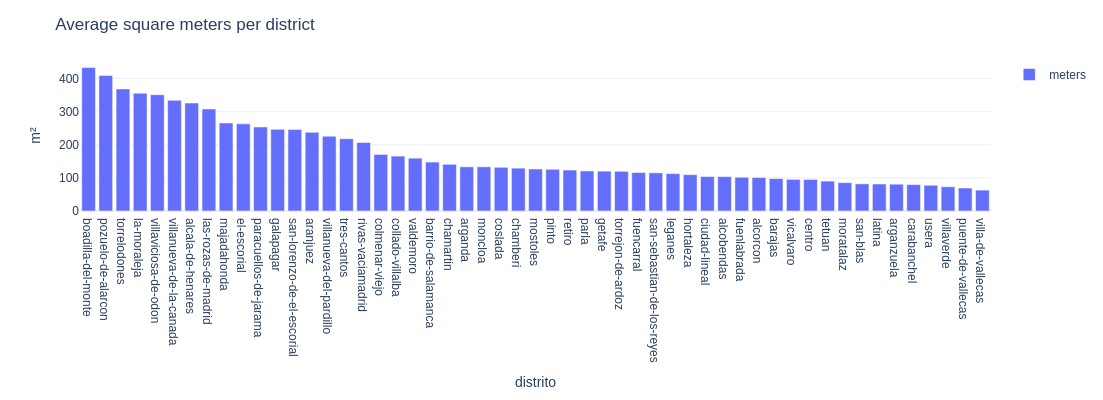

In [31]:
average_meters = df.groupby('distrito')['meters'].mean()
fig = px.bar(average_meters, color_continuous_scale=['viridis'])
fig.update_layout(
    width=1100,
    height=400,
    title="Average square meters per district",
    xaxis={'categoryorder': 'total descending'},
    yaxis_title='m²',
    legend_title_text=None,
    template='plotly_white')
fig.show()

### Plot average square meters on the map
To check if bigger neighborhoods are close to each other.

- **Spatial lag**: Captures the behaivor of the neigborhood for each variable.
- **Moran correlation**:

In [32]:
maps_df = gpd.GeoDataFrame(pd.merge(average_meters, maps, on='distrito'))
w = weights.Queen.from_dataframe(maps_df, ids='distrito')
w.transform = 'R'

maps_df = get_spatial_lag(maps_df, 'meters')

map1 = maps_df.explore(column='w_meters_norm', tiles="CartoDB positron")
map2 = maps_df.explore(column='meters_norm', tiles="CartoDB positron") 

map1_widget = widgets.Output(layout=widgets.Layout(width='1000px', height='400px'))
map2_widget = widgets.Output(layout=widgets.Layout(width='1000px', height='400px'))
map1_title = widgets.Label("Spatial lag Meters Normalized")
map2_title = widgets.Label("Meters Normalized")

with map1_widget:
    display(map1)
with map2_widget:
    display(map2)

# Organize the layout
map1_box = widgets.VBox([map1_title, map1_widget])
map2_box = widgets.VBox([map2_title, map2_widget])

hbox = widgets.VBox([map2_box, map1_box])
display(hbox)

('WARNING: ', 'aranjuez', ' is an island (no neighbors)')
('WARNING: ', 'coslada', ' is an island (no neighbors)')
('WARNING: ', 'tres-cantos', ' is an island (no neighbors)')
Variable: meters Moran correlation 0.5938283433033036


## Percentage of selling/renting apartments per district 

The bar plot represents the total apartments built per district. The line plots on top represent the percentage of apartments that are for sale or for rent in each district, check right y axis to know the values.

**Key Takeaways:**

- The most crouded districts are the ones on the left side of the plot, ex. carabanchel, latina, etc.
- In districts like centro, barrio de salamanca or la moraleja, the number of aparments for sale and for renting are considerably higher compared to the rest.
- What happens where there are high number of apartments for sale and low for rent? good place to invest?

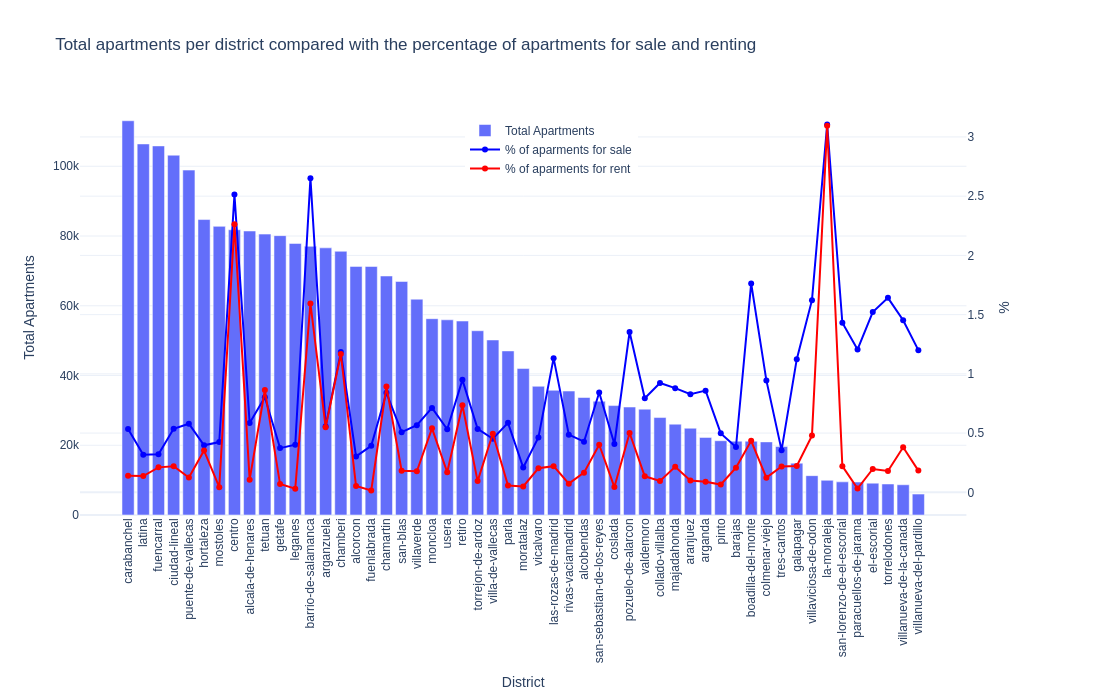

In [77]:
aux = data[['distrito', 'mean_meters', 'apartments', 'size_sell', 'size_rent', 'advertised_rent_time']].copy()
aux = aux.groupby(['distrito', 'apartments']).agg(
    {'size_sell': 'sum', 'size_rent': 'sum', 'advertised_rent_time': 'mean'}).reset_index()

aux['%sale'] = (aux['size_sell'] / aux['apartments']) * 100
aux['%rent'] = (aux['size_rent'] / aux['apartments']) * 100

aux = aux.sort_values(by='apartments', ascending=False)

title = 'Total apartments per district compared with the percentage of apartments for sale and renting'
fig = make_subplots(specs=[[{"secondary_y": True}]])

bar_trace = go.Bar(x=aux['distrito'], y=aux['apartments'], name='Total Apartments')
fig.add_trace(bar_trace, secondary_y=False)

sell_trace = go.Scatter(
    x=aux['distrito'], 
    y=aux['%sale'], 
    name='% of aparments for sale', 
    mode='lines+markers',
    line=dict(dash='solid', color='blue')
)
rent_trace = go.Scatter(
    x=aux['distrito'], 
    y=aux['%rent'], 
    name='% of aparments for rent', 
    mode='lines+markers',
    line=dict(dash='solid', color='red')
)
fig.add_trace(sell_trace, secondary_y=True)
fig.add_trace(rent_trace, secondary_y=True)

layout_dict = {
    'width': 1200,
    'height': 700,
    'title': title,
    'xaxis': dict(title='District', tickangle=-90),
    'template': 'plotly_white', 
    'legend': dict(yanchor='bottom', y=0.8, xanchor='center', x=0.5)
}
fig.update_layout(**layout_dict)
fig.update_yaxes(title_text="Total Apartments", secondary_y=False)
fig.update_yaxes(title_text="%", secondary_y=True)
fig.update_layout(hovermode='x unified')
fig.show()

### Map plot of the %sale

In [50]:
maps_df = gpd.GeoDataFrame(pd.merge(aux, maps, on='distrito'))
maps_df = maps_df.to_crs(epsg=4326)

maps_df = get_spatial_lag(maps_df, 'apartments')

m = maps_df.explore(column='apartments_norm', tiles="CartoDB positron")

for _, row in maps_df.iterrows():
    centroid = row.geometry.centroid
    radius = row['size_sell'] / 50
    folium.CircleMarker(
        location=[centroid.y, centroid.x],
        radius=radius,  
        color='blue',
        fill=True,
        stroke=False,
        fill_color='blue',
        fill_opacity=0.4
    ).add_to(m)
m

Variable: apartments Moran correlation -0.016684728421349652


## Average price per square meter (€/m²)

The two plots display the mean cost per square meter (€/m²) of properties for sale and rent, respectively, across different districts. Each line in the plots represents a specific property size category (e.g., 30 m², 50 m², etc.) with a color scale.

1. **Rental Market**: This plot illustrates the variations in mean €/m² for rental properties across districts.
2. **Sale Market**: This plot shows the variations in mean €/m² for property sale prices across districts.


**Key Takeaways**
- The rental market fluctuates way more than the selling market
- Smaller apartments are more expensive to rent per square meter than bigger apartments

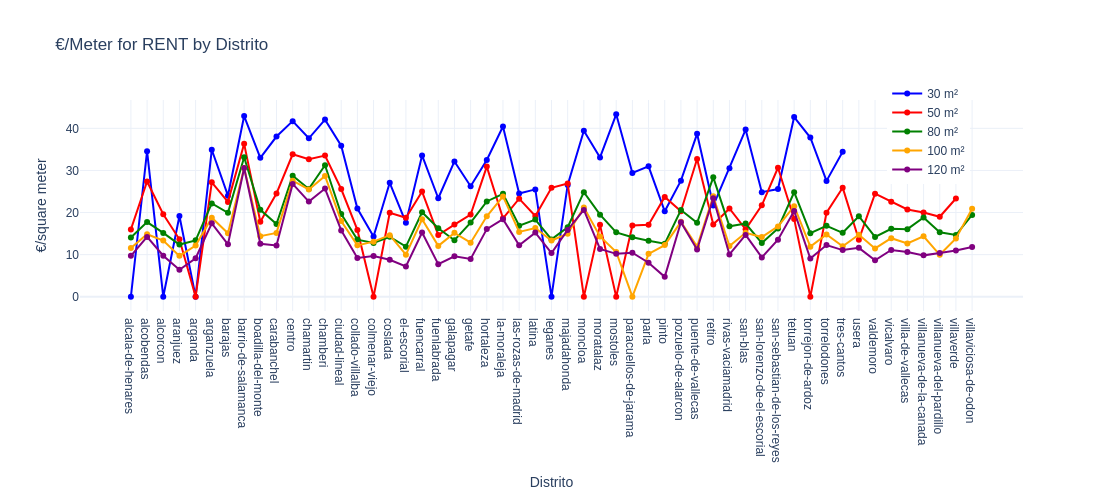

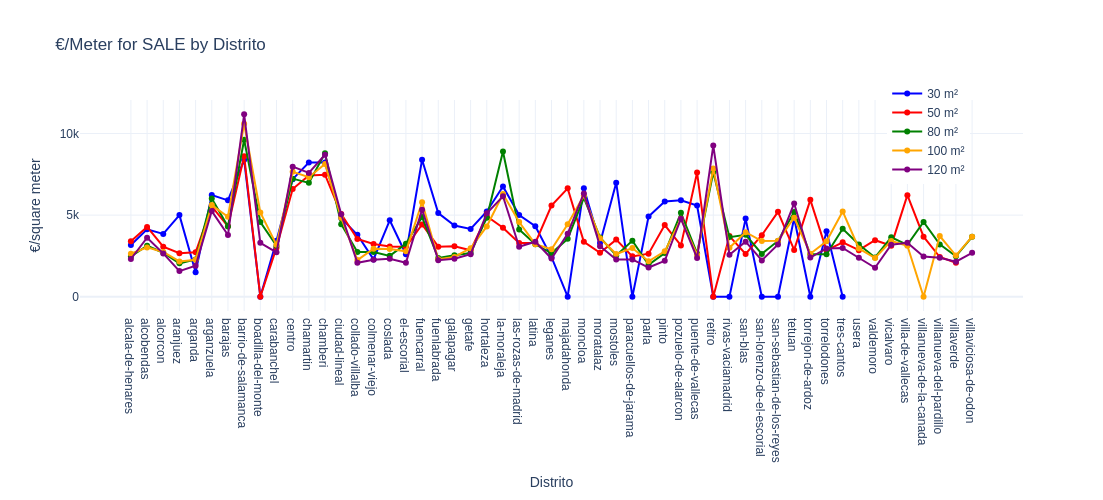

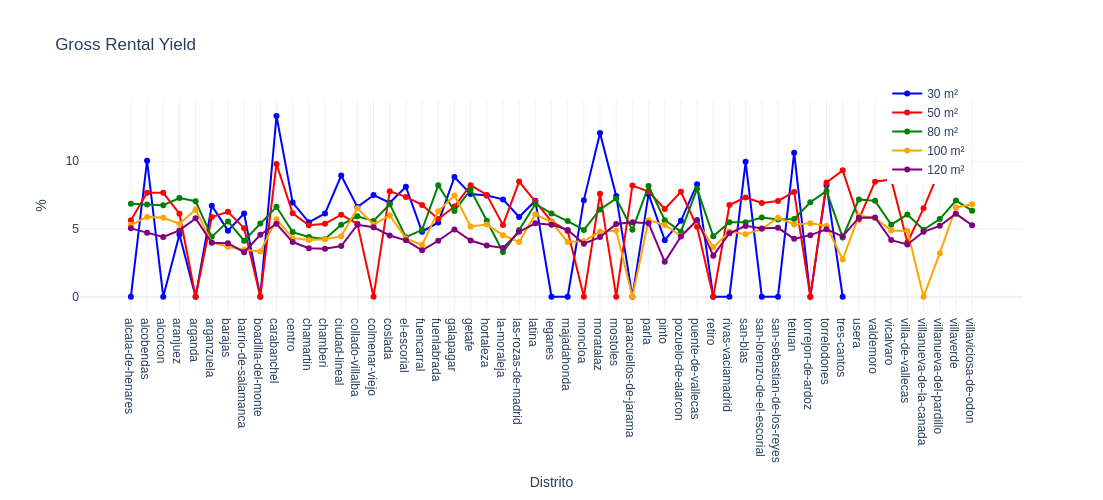

In [161]:
def square_meter_price(aux, item, title, yaxis):
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    _iter = iter(colors)
    distritos = aux.distrito.unique().tolist()
    fig = go.Figure()
    for meter in aux.mean_meters.unique():
        _30 = aux[aux['mean_meters'] == meter].copy()
        _30 = _30.rename(columns={item: f'{item}_{meter}'})
        fig.add_trace(
            go.Scatter(
                x=distritos,
                y=_30[f'{item}_{meter}'],
                name=f'{int(meter)} m²',
                mode="lines+markers",
                line=dict(color=next(_iter))
            )
        )
    fig.update_layout(
        height=500,
        title=title,
        xaxis=dict(title="Distrito"),
        yaxis=dict(title=yaxis),
        template='plotly_white',
        legend=dict(x=0.9, y=1.1, xanchor="center")
    )
    fig.update_layout(hovermode='x unified')
    fig.show()
    
aux = data[['distrito', 'mean_meters', '€/meter_rent', '€/meter_sell', 'RB']].copy()     
square_meter_price(aux, '€/meter_rent', title="€/Meter for RENT by Distrito", yaxis="€/square meter")
square_meter_price(aux, '€/meter_sell', title="€/Meter for SALE by Distrito", yaxis="€/square meter")
square_meter_price(aux, 'RB', title="Gross Rental Yield", yaxis="%")

## Map with the average apartments prices per district

In [163]:
aux = aux.groupby('distrito').agg({'RB': 'mean', '€/meter_rent': 'mean', '€/meter_sell': 'mean'}).reset_index()
maps_df = gpd.GeoDataFrame(pd.merge(aux, maps, on='distrito'))
w = weights.Queen.from_dataframe(maps_df, ids='distrito')
w.transform = 'R'

maps_df = get_spatial_lag(maps_df, 'RB')

tooltips = ['distrito', 'RB', '€/meter_rent', '€/meter_sell']
map1 = maps_df.explore(column='RB_norm', tiles="CartoDB positron", highlight=True, tooltip=tooltips)
#map2 = maps_df.explore(column='w_RB_norm', tiles="CartoDB positron", highlight=True, tooltip=tooltips) # Plot the spatial lag
map1

('WARNING: ', 'aranjuez', ' is an island (no neighbors)')
('WARNING: ', 'coslada', ' is an island (no neighbors)')
('WARNING: ', 'tres-cantos', ' is an island (no neighbors)')
Variable: RB Moran correlation 0.06335668407489813


## Property Size vs. Price Across Districts

This scatter plot examines the relationship between property size (in square meters) and price across different districts. 
Each point represents the average values of all the properties in that district.

**Key Takeaways:**
- Clusters indicate similar size-price relationships within districts.
- Outliers may represent premium properties (ex. barrio-de-salamanca, pozuelo) or undervalued ones (ex. alcala-de-henares, aranjuez).
- Helps identify whether larger properties consistently lead to higher prices.

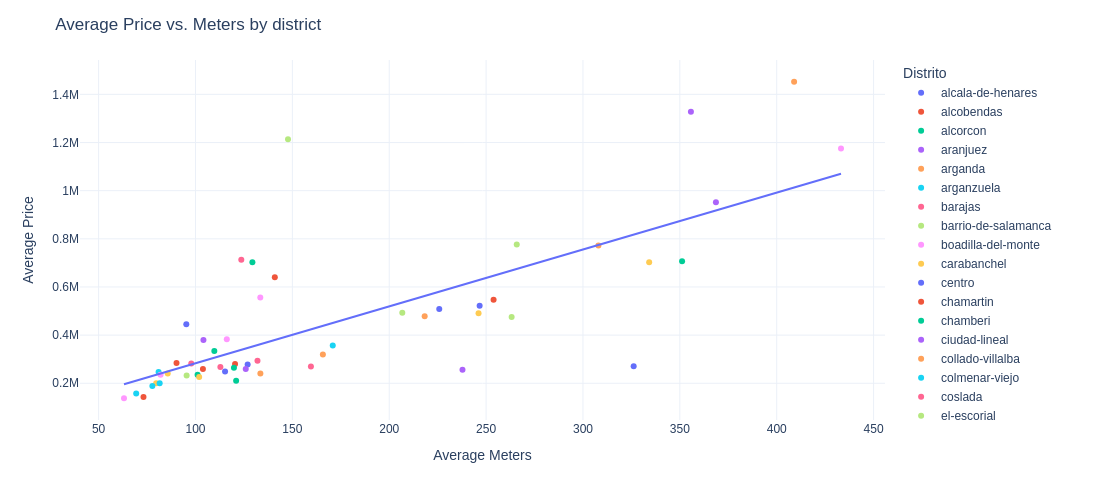

In [78]:
grouped = df.groupby('distrito').agg({'price': 'mean', 'meters': 'mean'}).reset_index()

slope, intercept = np.polyfit(grouped['meters'], grouped['price'], 1)
trend_x = np.linspace(grouped['meters'].min(), grouped['meters'].max(), 100)
trend_y = slope * trend_x + intercept

fig = px.scatter(grouped, x='meters', y='price', color='distrito')
fig.add_traces(px.line(x=trend_x, y=trend_y).data)
fig.update_layout(
    width=1000,
    height=500,
    title='Average Price vs. Meters by district',
    xaxis_title='Average Meters',
    yaxis_title='Average Price',
    legend_title='Distrito',
    template='plotly_white'
)

## Average advertisement time aparments are on Idealista

We are assuming that the last time each add has been updated is the moment when the apartment enter the selling or renting market. 

The time is measured in months and the apartments are divided according to their size.


1. **Fastest apartments to rent out**
- The first plot shows, for each district which size of apartments are rented out the fastest. The color indicates the size and the y left axis indicates how many months are posted on idealista.
- The red points are the Gross Rental Yield for each group of apartments.
- The goal of this plot is to get the apartments that take less time to rent out per district, and check their rental yield. The best one will be the one with less time and highest rental yield, For example, el escorial or parla satisfied those conditions. 

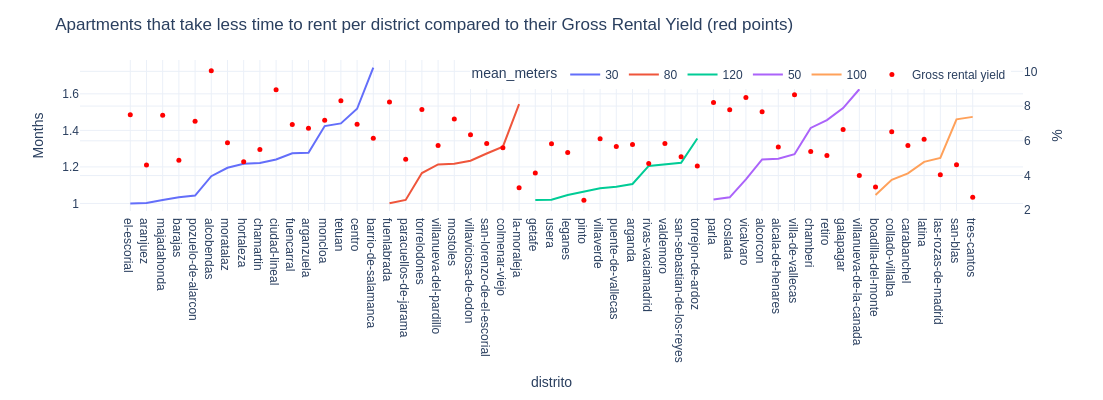

In [82]:
aux = data[['distrito', 'mean_meters', 'advertised_rent_time', 'advertised_sell_time', 'RB']].copy()
aux = aux[(aux != 0).all(axis=1)]
aux['mean_meters'] = aux['mean_meters'].apply(lambda x: int(x))

min_rows = aux.loc[aux.groupby('distrito')['advertised_rent_time'].idxmin()]
min_rows = min_rows.sort_values(by=['advertised_rent_time'])

title = 'Apartments that take less time to rent per district compared to their Gross Rental Yield (red points)'

fig = px.line(min_rows, x='distrito', y=['advertised_rent_time'], color='mean_meters')
fig.add_trace(
    go.Scatter(
        x=min_rows['distrito'],
        y=min_rows['RB'],
        mode='markers',
        name='Gross rental yield',
        marker=dict(color='red', size=5),
        yaxis='y2'
    )
)

fig.update_layout(
    title=title, 
    height=400,
    yaxis=dict(title="Months"),
    yaxis2=dict(
        title="%",
        overlaying='y',
        side='right'
    ),
    template='plotly_white',
    legend=dict(x=0.7, y=1, xanchor="center", orientation='h')
)
fig.update_layout(hovermode='x unified')
fig.show()

## Comparison between Gross rental yield and PER

The districts on the left side of the plot are the most interesting to invest on, in terms of less PER (number of years to recover the investment) and higher gross rental yield. 

The revaluation is represented with the radius points. The wider the point the more will your apartment cost after the PER years. 

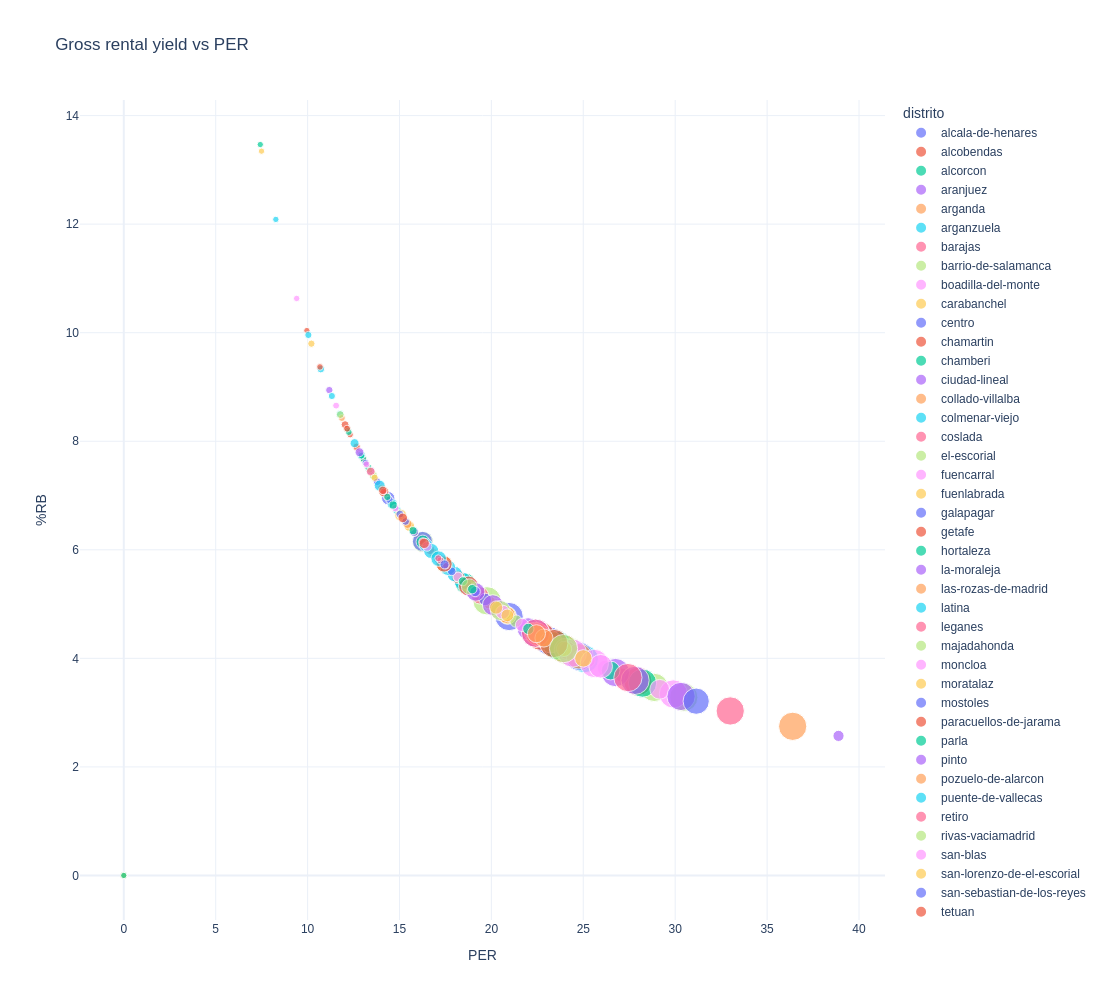

In [135]:
aux = data[['distrito', 'RB', 'PER', 'PER_adjusted', 'mean_meters', 'revaluation']].copy()

lower_bound = aux['revaluation'].quantile(0.1)
upper_bound = aux['revaluation'].quantile(0.9)
aux['revaluation_clipped'] = aux['revaluation'].clip(lower_bound, upper_bound)

scaler = MinMaxScaler(feature_range=(1, 20))
aux['revaluation_norm'] = scaler.fit_transform(aux[['revaluation_clipped']])

title = 'Gross rental yield vs PER'
fig = px.scatter(aux, x='PER', y='RB', color='distrito', title=title, size='revaluation_norm', hover_data=['PER', 'revaluation', 'mean_meters'])
fig.update_layout(
    title=title, 
    height=800,
    yaxis=dict(title="%RB"),
        yaxis2=dict(
        title="Money",
        overlaying='y',
        side='right'
    ),
    template='plotly_white',
)

## Revaluation vs Gross Rental Yield

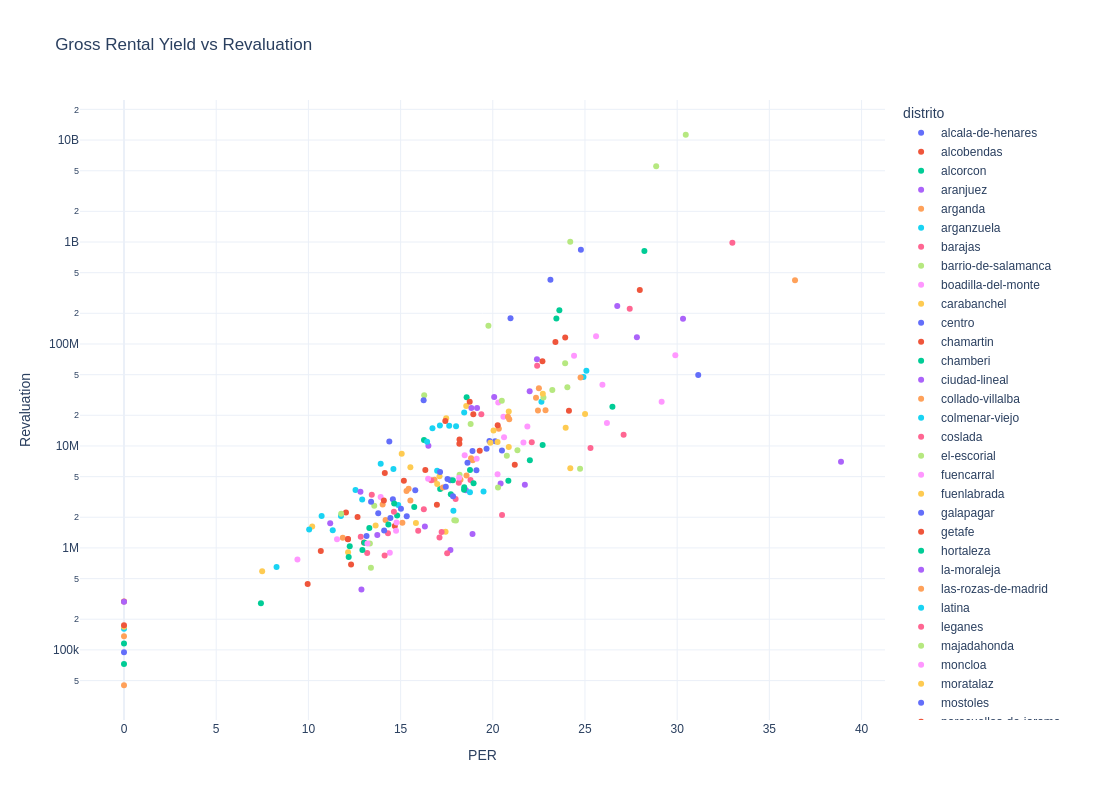

In [136]:
title='Gross Rental Yield vs Revaluation'
fig = px.scatter(aux, x='PER', y='revaluation', color='distrito', title=title, hover_data=['PER', 'revaluation', 'mean_meters'])
fig.update_layout(
    title=title, 
    height=800,
    yaxis=dict(title="Revaluation", type='log'),
    template='plotly_white',
)